DATA USED : https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip

## Why waste sorting?

Recycling contamination occurs when waste is incorrectly disposed of - like recycling a pizza box with oil on it (compost). Or when waste is correctly disposed of but incorrectly prepared - like recycling unrinsed jam jars.

## Building an image classifier

In this project, we'll train a convolutional neural network to classify an image as either cardboard, glass, metal, paper, plastic, or trash with the fastai library (built on PyTorch). I used an image dataset collected manually by Gary Thung and Mindy Yang. Download their dataset [here](https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip) to follow along, then move it to the same directory as this notebook. (Note: you'll want to use a GPU to speed up training.)


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

## 1. Extract data

First, we need to extract the contents of "dataset-resized.zip".

In [ ]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['metal', 'paper', 'plastic', 'glass', 'cardboard', '.DS_Store', 'trash']

## 2. Organize images into different folders

Now that we've extracted the data, I'm going to split images up into train, validation, and test image folders with a 50-25-25 split. First, I'll define some functions that will help me quickly build it. If you're not interested in building the data set, you can just run this ignore it.

In [ ]:
  def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    remain = list(set(full_set)-set(train))

    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    
    
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, I'm going to create a bunch of destination folders according to the ImageNet directory convention. It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)

Again, this is just housekeeping to organize my files.

In [ ]:

subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))

for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    

    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    

    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    

    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
   
    move_files(test_source_files,"data/test")

In [ ]:
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

The batch size bs is how many images you'll train at a time. Choose a smaller batch size if your computer has less memory. 

You can use get_transforms() function to augment your data. I'll compare the results from flipping images horizontally and vertically.

In [ ]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
metal,metal,metal,metal,metal
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [ ]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Here's an example of what the data looks like:

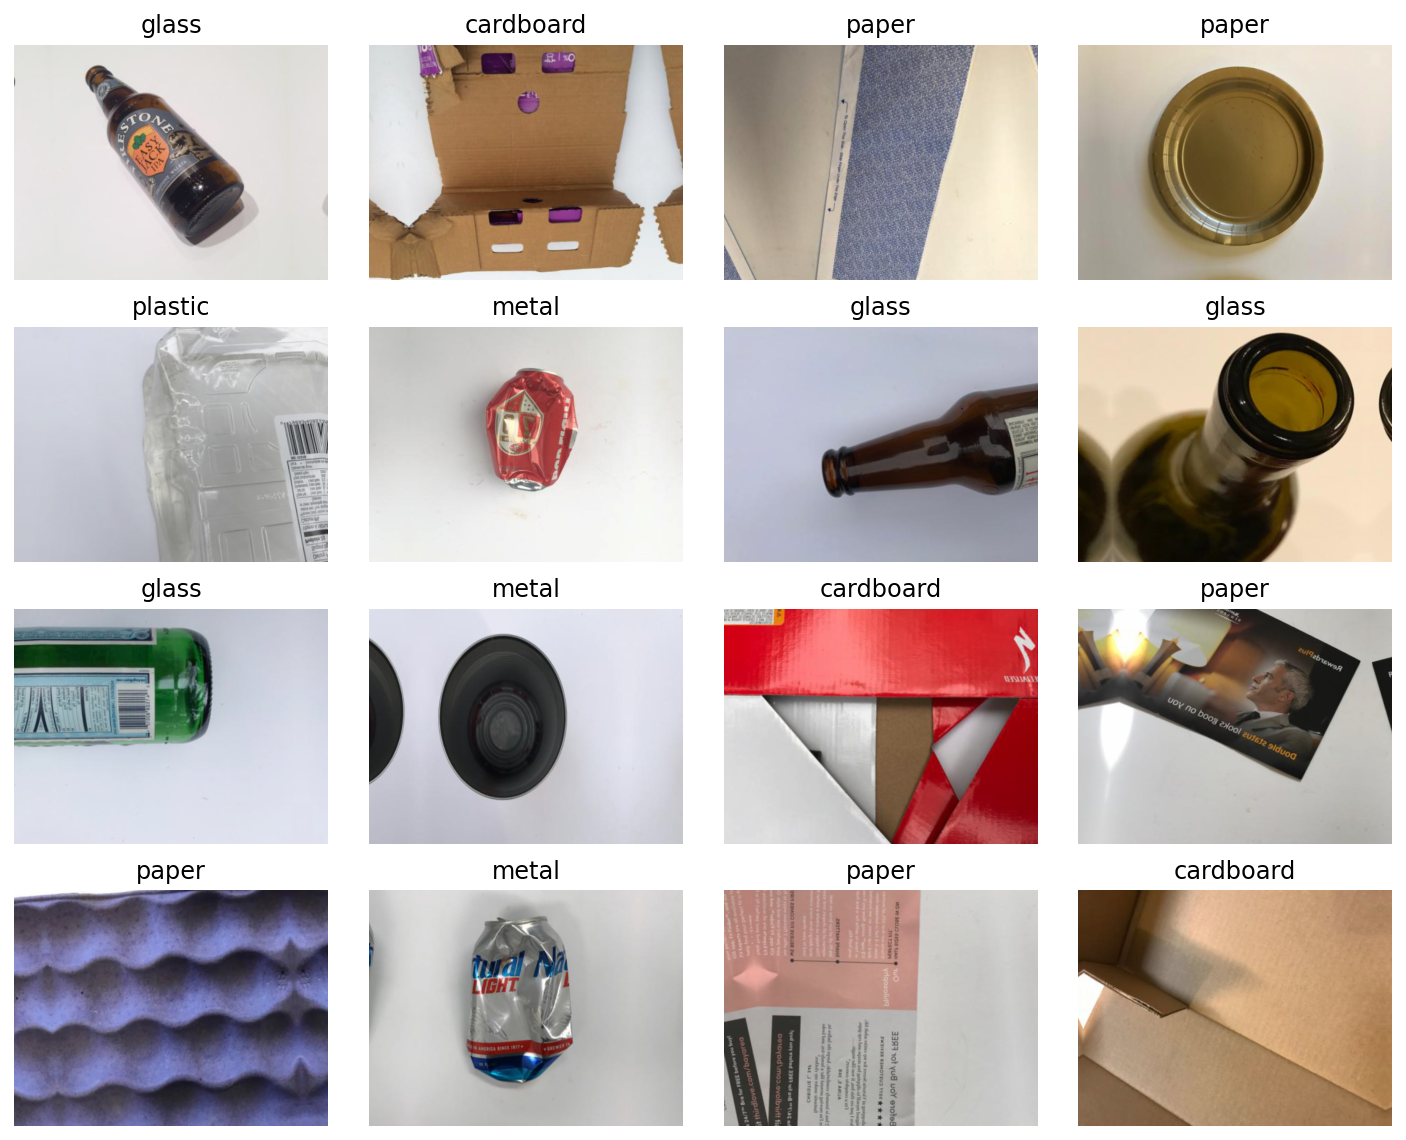

In [ ]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

In [ ]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


### What is resnet34?

A residual neural network is a [convolutional neural network (CNN)](https://towardsdatascience.com/convolutional-neural-networks-for-beginners-practical-guide-with-python-and-keras-dc688ea90dca) with lots of layers. In particular, resnet34 is a CNN with 34 layers that's been pretrained on the [ImageNet database](http://www.image-net.org/). A pretrained CNN will perform better on new image classification tasks because it has already learned some visual features and can transfer that knowledge over (hence transfer learning).

Since they're capable of describing more complexity, deep neural networks should theoretically perform better than shallow networks on training data. In reality, though, deep neural networks tend to perform empirically worse than shallow ones. 

Resnets were created to circumvent this glitch using a hack called shortcut connections. If some nodes in a layer have suboptimal values, you can adjust weights and bias; if a node is optimal (its residual is 0), why not leave it alone? Adjustments are only made to nodes on an as-needed basis (when there's non-zero residuals). 

When adjustments are needed, shortcut connections apply the identity function to pass information to subsequent layers. This shortens the neural network when possible and allows resnets to have deep architectures and behave more like shallow neural networks. The 34 in resnet34 just refers to the number of layers.

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Finding a learning rate

I'm going to find a learning rate for gradient descent to make sure that my neural network converges reasonably quickly without missing the optimal error.  rate. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


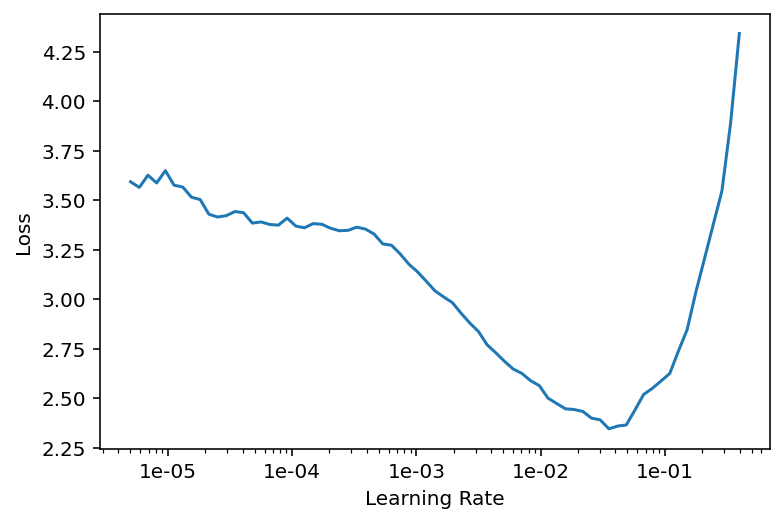

In [ ]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

The learning rate finder suggests a learning rate of 5.13e-03. With this, we can train the model.

### Training

In [ ]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.711878,0.730204,0.252381,00:34
1,1.154575,0.536344,0.169841,00:33
2,0.922753,0.584122,0.179365,00:33
3,0.809356,0.572862,0.155556,00:34
4,0.741950,0.711420,0.217460,00:34
5,0.868784,0.636283,0.215873,00:34
6,0.789176,0.732412,0.220635,00:34
7,0.727628,0.673028,0.214286,00:34
8,0.689859,0.664525,0.207937,00:34
9,0.569931,0.459736,0.163492,00:34


we ran my model for 20 epochs. What's cool about this fitting method is that the learning rate decreases with each epoch, allowing us to get closer and closer to the optimum. At 8.6%, the validation error looks super good... let's see how it performs on the test data though. 

First, we can take a look at which images were most incorrectly classified.

### VIsualizing most incorrect images

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

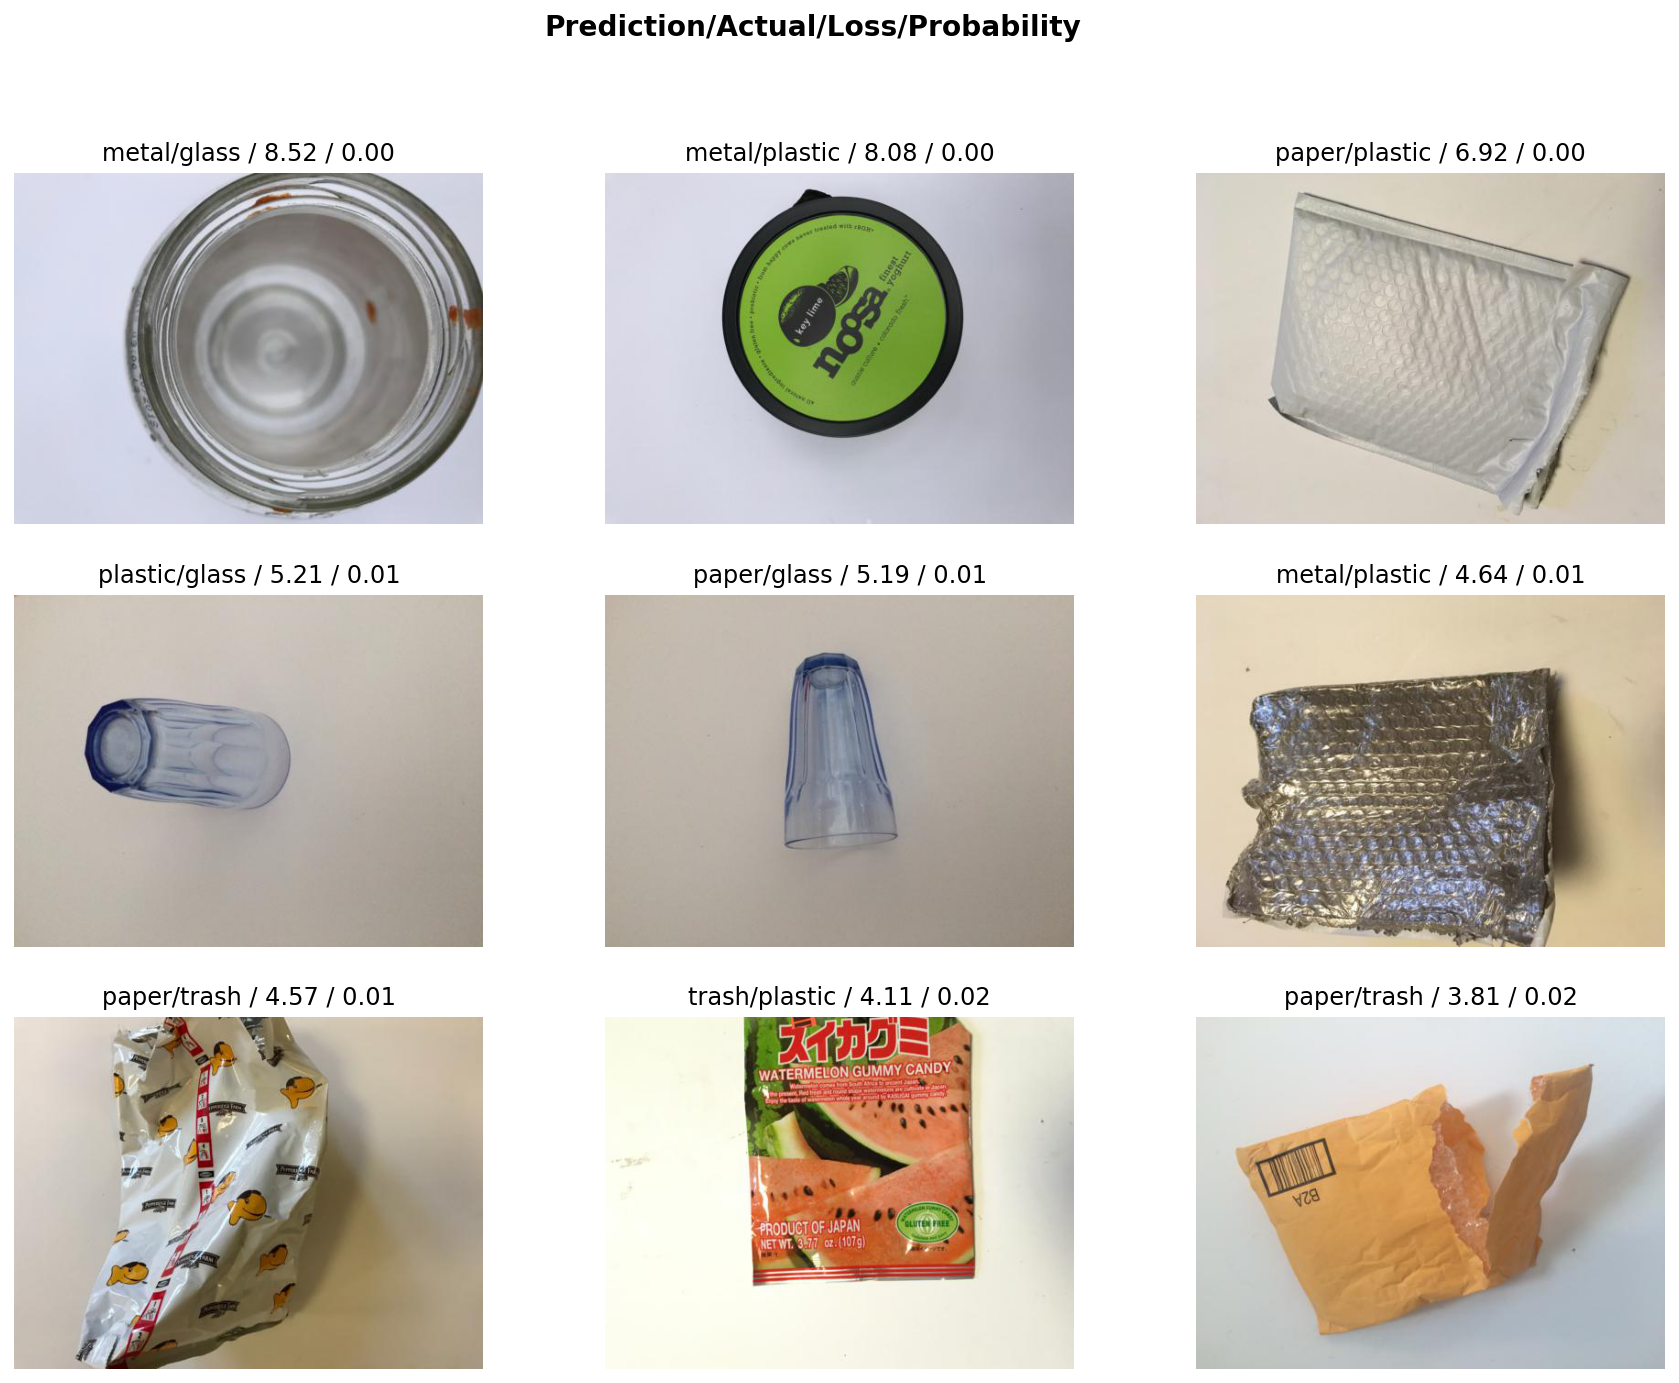

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

The images here that the recycler performed poorly on were actually degraded. It looks the photos received too much exposure or something so this actually isn't a fault with the model!

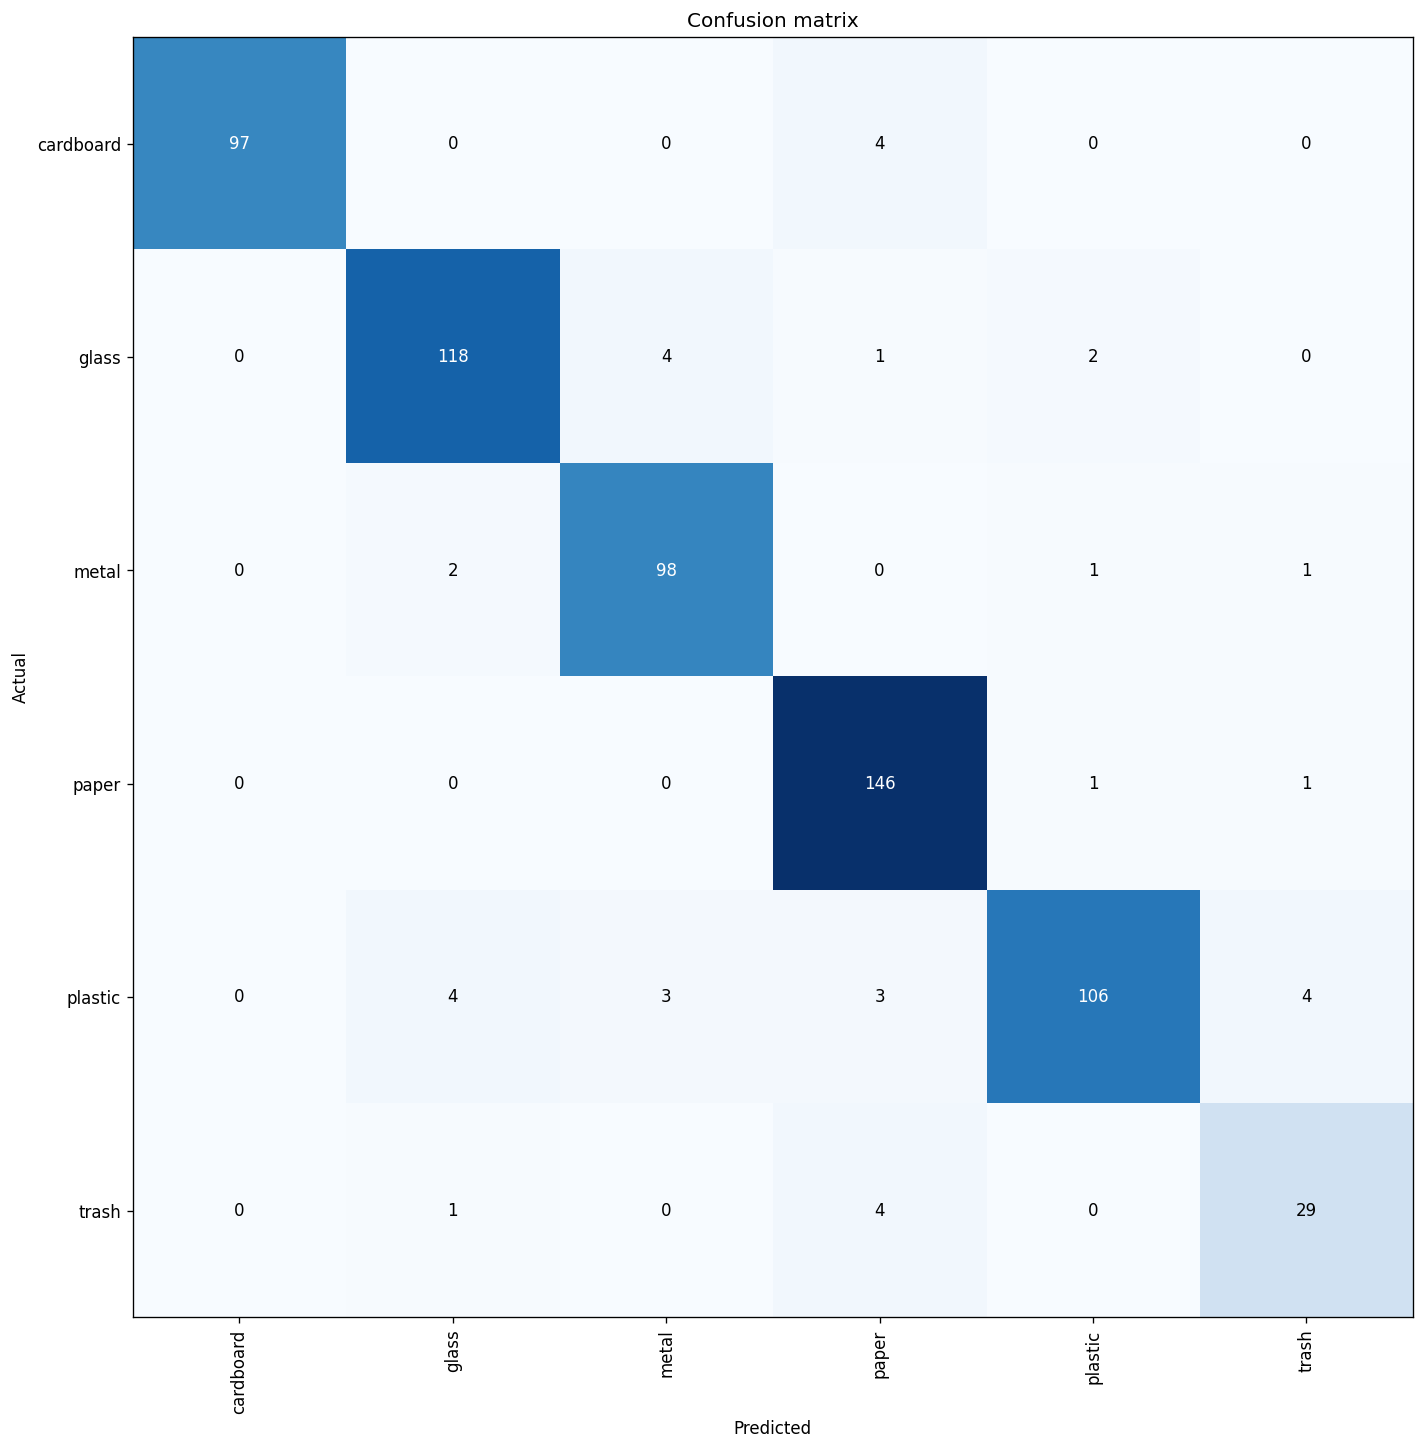

In [ ]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused plastic for glass and confused metal for glass. The list of most confused images is below.

In [ ]:
interp.most_confused(min_val=2)

[('cardboard', 'paper', 4),
 ('glass', 'metal', 4),
 ('plastic', 'glass', 4),
 ('plastic', 'trash', 4),
 ('trash', 'paper', 4),
 ('plastic', 'metal', 3),
 ('plastic', 'paper', 3),
 ('glass', 'plastic', 2),
 ('metal', 'glass', 2)]

## 4. Make new predictions on test data


In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)

The ds_type argument in get_preds(ds_type) takes a [DataSet](https://docs.fast.ai/basic_data.html#DatasetType) argument. Example values are DataSet.Train, DataSet.Valid, and DataSet.Test. 

In [ ]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[3.2074e-04, 9.9152e-01, 2.0525e-04, 2.9570e-03, 4.8810e-03, 1.1579e-04],
        [7.4488e-05, 6.4106e-01, 2.4501e-01, 7.3289e-06, 1.1380e-01, 4.9990e-05],
        [1.6707e-07, 9.9982e-01, 4.5360e-06, 8.2000e-08, 1.6771e-04, 1.1260e-05],
        ...,
        [9.9815e-01, 5.6230e-06, 1.2177e-04, 1.1986e-03, 1.6419e-04, 3.6403e-04],
        [5.8686e-05, 4.7097e-01, 6.8210e-03, 1.8121e-02, 5.0383e-01, 1.9744e-04],
        [1.0000e+00, 4.0947e-09, 2.2310e-10, 6.2429e-08, 2.1773e-09, 9.6317e-07]])

These are the predicted probablities for each image. This tensor has 365 rows -- one for each image -- and 6 columns -- one for each material category.

In [ ]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Now we are going to convert the probabilities in the tensor above to a string with one of the class names.

In [ ]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [ ]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [ ]:
yhat

['glass',
 'glass',
 'glass',
 'trash',
 'trash',
 'paper',
 'metal',
 'cardboard',
 'glass',
 'plastic',
 'glass',
 'trash',
 'paper',
 'cardboard',
 'glass',
 'metal',
 'metal',
 'paper',
 'paper',
 'metal',
 'metal',
 'glass',
 'metal',
 'metal',
 'plastic',
 'plastic',
 'plastic',
 'paper',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'paper',
 'plastic',
 'plastic',
 'metal',
 'paper',
 'metal',
 'plastic',
 'paper',
 'cardboard',
 'glass',
 'paper',
 'glass',
 'glass',
 'metal',
 'plastic',
 'trash',
 'plastic',
 'glass',
 'metal',
 'glass',
 'plastic',
 'cardboard',
 'plastic',
 'cardboard',
 'plastic',
 'paper',
 'cardboard',
 'cardboard',
 'cardboard',
 'metal',
 'metal',
 'cardboard',
 'plastic',
 'glass',
 'plastic',
 'metal',
 'cardboard',
 'paper',
 'plastic',
 'trash',
 'trash',
 'metal',
 'trash',
 'plastic',
 'glass',
 'metal',
 'glass',
 'cardboard',
 'glass',
 'plastic',
 'metal',
 'glass',
 'glass',
 'paper',
 'metal',
 'paper',
 'paper',
 'glass',
 'glass',
 'metal'

These are the predicted labels of all the images! Let's check if the first image is actually glass.

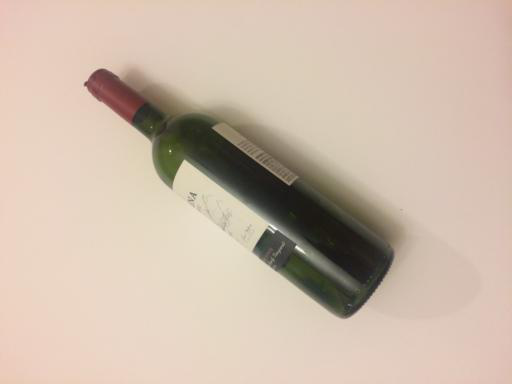

In [ ]:
learn.data.test_ds[0][0]

It is!

Next, we'll get the actual labels from the test dataset.

In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [ ]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['glass', 'glass', 'glass', 'trash', 'trash']
['glass', 'glass', 'glass', 'trash', 'trash']


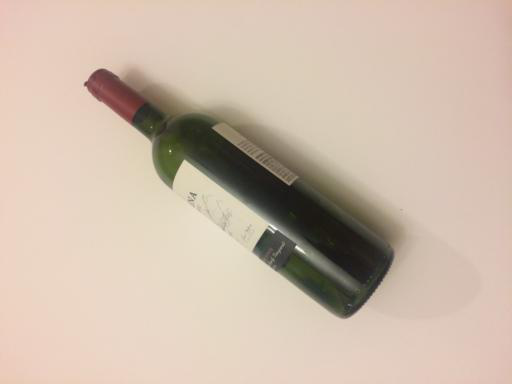

In [ ]:
learn.data.test_ds[0][0]



### Test confusion matrix

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 94   0   2   2   2   1]
 [  0 109   8   0   9   0]
 [  2   5  93   0   1   2]
 [  0   0   0 145   1   3]
 [  0   5   0   0 113   3]
 [  1   0   1   3   1  29]]


Let's try and make this matrix a little prettier.

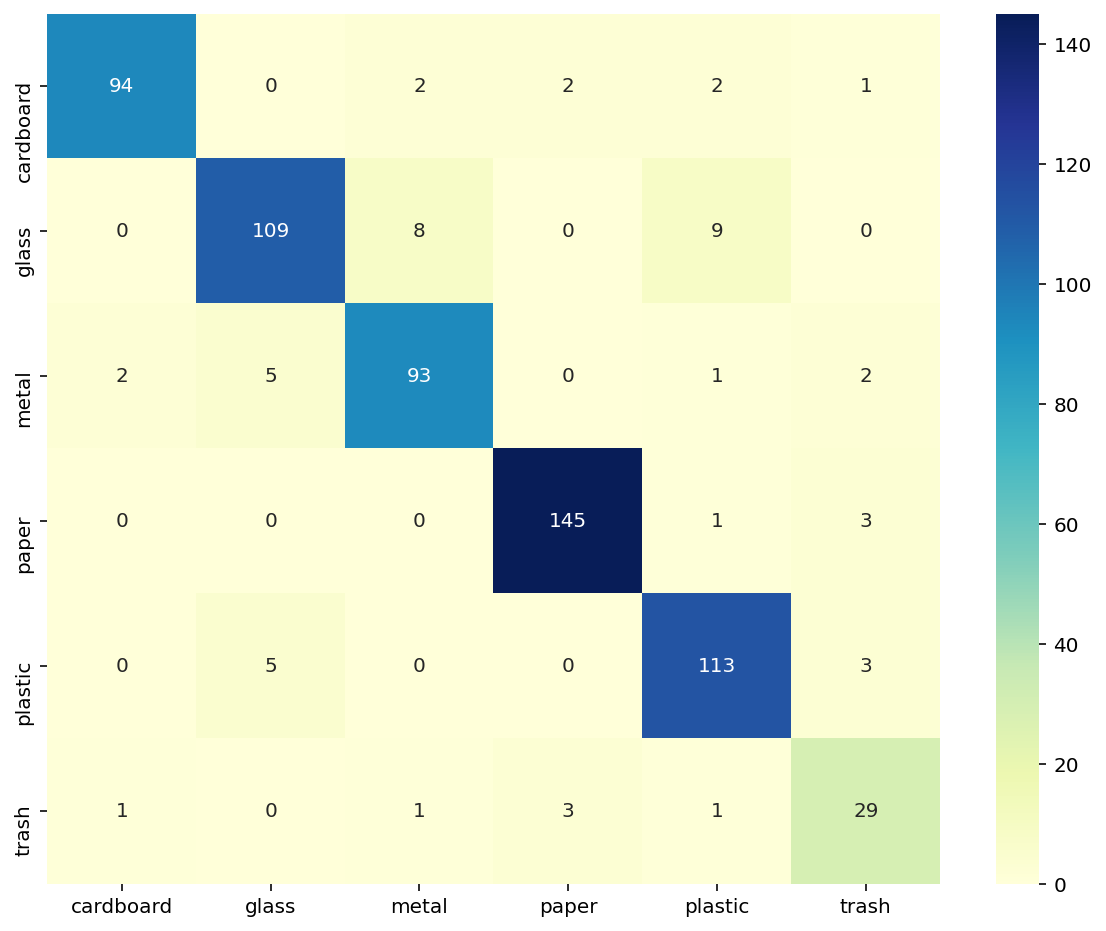

In [ ]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Again, the model seems to have confused metal for glass and plastic for glass. With more time, I'm sure further investigation could help reduce these mistakes.

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

0.9181102362204724

We ended up achieving an accuracy of 91.8%

In [ ]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')

## 5. Next steps

The same model could be integrated to android or GoPros and classification using a bounding box could also be added to it along with the above model.